In [26]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sqlalchemy import create_engine
from scipy.stats import chi2_contingency


marketing_campaign_df = pd.read_csv("../data/clean/ Marketing_Campaign_final.csv")
marketing_campaign_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,client_age,job_category,marital_status,education_level,has_credit_default,account_balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,...,call_duration_sec,contacts_this_campaign,days_since_prev_contact,nb_previous_interactions,prev_campaign_outcome,has_subscribed_target,month_num,year,ecb_rate,campaign_channel
0,58,management,married,tertiary,0,2143,1,0,not_reported,5,...,261,1,999,0,not_reported,0,5,2008,3.0,Unknown
1,44,technician,single,secondary,0,29,1,0,not_reported,5,...,151,1,999,0,not_reported,0,5,2008,3.0,Unknown
2,33,entrepreneur,married,secondary,0,2,1,1,not_reported,5,...,76,1,999,0,not_reported,0,5,2008,3.0,Unknown
3,47,blue-collar,married,not_reported,0,1506,1,0,not_reported,5,...,92,1,999,0,not_reported,0,5,2008,3.0,Unknown
4,33,not_reported,single,not_reported,0,1,0,0,not_reported,5,...,198,1,999,0,not_reported,0,5,2008,3.0,Unknown


In [3]:
# Save the UCI dataset in the raw folder
#uci_bank_marketing = df.copy()
#uci_bank_marketing.to_csv("../data/raw/uci_bank_marketing.csv", index=False)



## Hypothesis 1: Higher ECB interest rates increase the likelihood of term deposit subscriptions.

C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\2523088030.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_by_rate = marketing_campaign_df.groupby('rate_bin')['has_subscribed_target'].mean().reset_index()
C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\2523088030.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_by_rate, x='rate_bin', y='has_subscribed_target', palette='Blues')


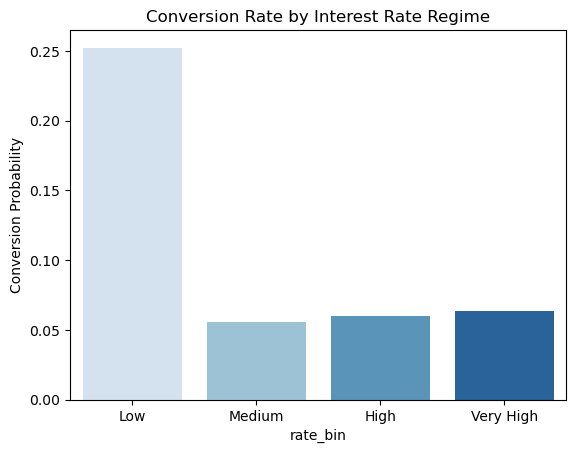

In [4]:
# Create bins for interest rates
marketing_campaign_df['rate_bin'] = pd.qcut(marketing_campaign_df['ecb_rate'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Calculate conversion rate per bin
conversion_by_rate = marketing_campaign_df.groupby('rate_bin')['has_subscribed_target'].mean().reset_index()

# Plot
sns.barplot(data=conversion_by_rate, x='rate_bin', y='has_subscribed_target', palette='Blues')
plt.title("Conversion Rate by Interest Rate Regime")
plt.ylabel("Conversion Probability")
plt.show()

## Hypothesis 2: Marketing campaigns launched during high-rate periods perform significantly better than those in low-rate periods.

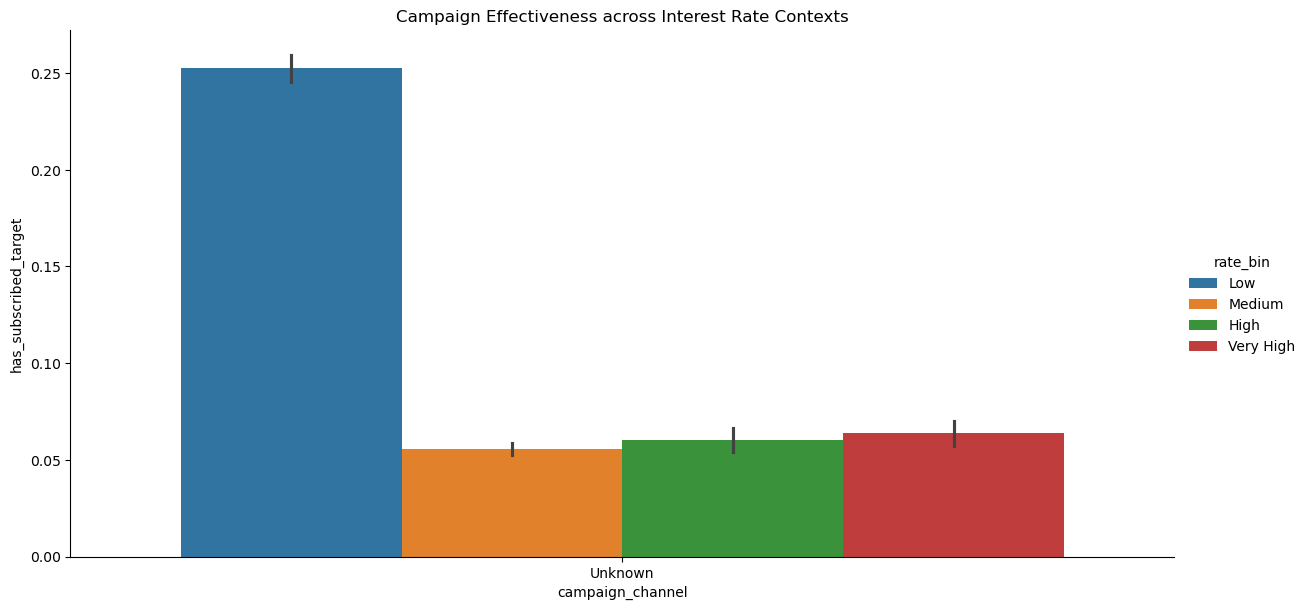

In [5]:
# Interaction effect visualization
sns.catplot(
    data=marketing_campaign_df, kind="bar",
    x="campaign_channel", y="has_subscribed_target", hue="rate_bin",
    height=6, aspect=2
)
plt.title("Campaign Effectiveness across Interest Rate Contexts")
plt.show()

## Hypothesis 3: Digital channels (if available) or specific contact types (Cellular vs. Telephone) respond differently to economic pressure.

C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\3985394656.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = marketing_campaign_df.pivot_table(


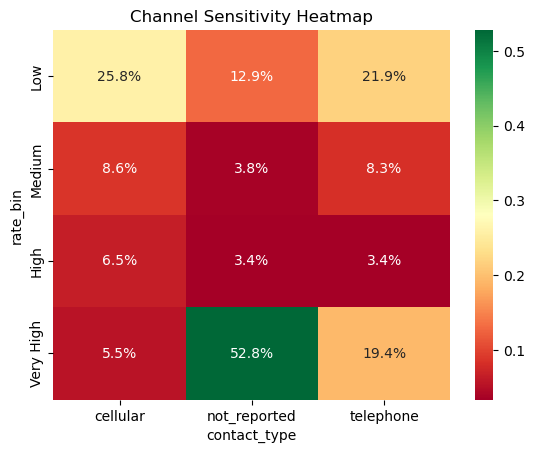

In [6]:
pivot = marketing_campaign_df.pivot_table(
    index='rate_bin', 
    columns='contact_type', 
    values='has_subscribed_target', 
    aggfunc='mean'
)
sns.heatmap(pivot, annot=True, cmap='RdYlGn', fmt=".1%")
plt.title("Channel Sensitivity Heatmap")
plt.show()

## Hypothesis 4: High-balance clients are more elastic (sensitive) to interest rate changes than low-balance clients.

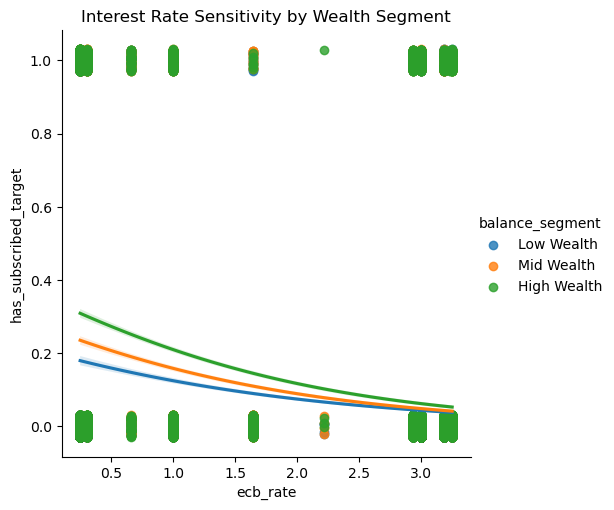

In [7]:
# Segment clients by balance
marketing_campaign_df['balance_segment'] = pd.qcut(marketing_campaign_df['account_balance'], q=3, labels=['Low Wealth', 'Mid Wealth', 'High Wealth'])

# Viz
sns.lmplot(
    data=marketing_campaign_df, x="ecb_rate", y="has_subscribed_target", 
    hue="balance_segment", logistic=True, y_jitter=0.03
)
plt.title("Interest Rate Sensitivity by Wealth Segment")
plt.show()

# Subscription Rate by Job Category (Bar Chart)

C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\888791506.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\888791506.py:20: UserWarning: 
The palette list has fewer values (4) than needed (12) and will cycle, which may produce an uninterpretable plot.
  barplot = sns.barplot(


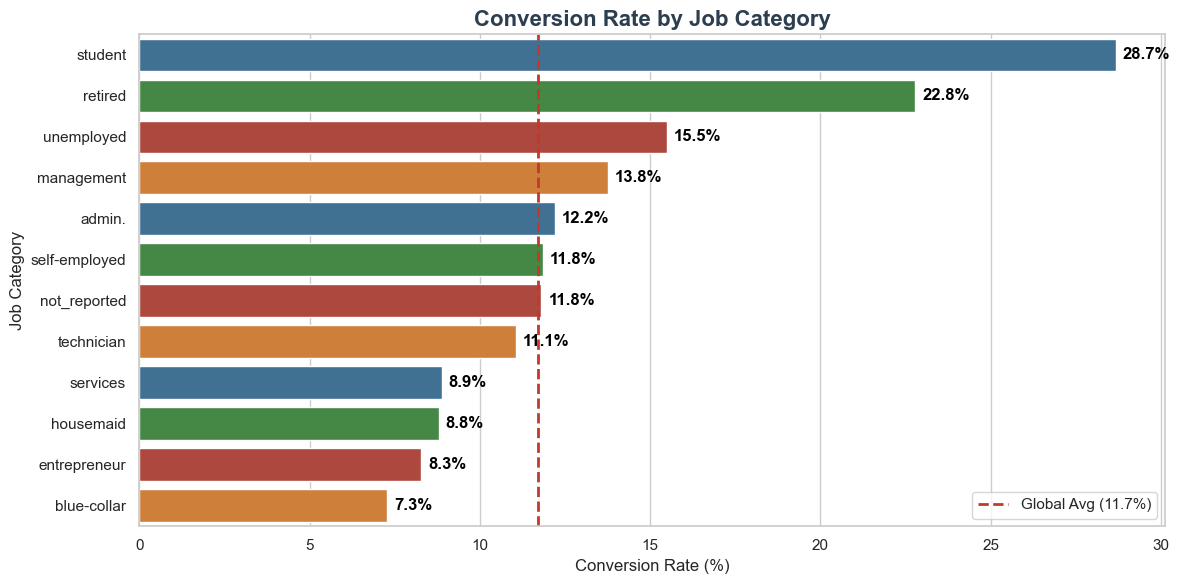

In [10]:
# ==============================================
# 0. SETUP YOUR CUSTOM COLORS
# ==============================================
# Extracted from your uploaded image (Blue, Green, Red, Orange)
custom_colors = ["#3274A1", "#3A923A", "#C0392B", "#E67E22"]
sns.set_palette(sns.color_palette(custom_colors))
sns.set_theme(style="whitegrid")

# ==============================================
# VIZ 1: Subscription Rate by Job Category (Bar Chart)
# ==============================================

# A. Prepare Data
job_stats = marketing_campaign_df.groupby('job_category')['has_subscribed_target'].mean().reset_index()
job_stats['conversion_rate_pct'] = job_stats['has_subscribed_target'] * 100
job_stats = job_stats.sort_values('conversion_rate_pct', ascending=False)

# B. Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=job_stats, 
    x='conversion_rate_pct', 
    y='job_category', 
    palette=custom_colors  # Using your custom colors here
)

# C. Customize
plt.title('Conversion Rate by Job Category', fontsize=16, fontweight='bold', color='#2C3E50')
plt.xlabel('Conversion Rate (%)', fontsize=12)
plt.ylabel('Job Category', fontsize=12)

# Add Global Average Line (Red from your palette)
global_mean = marketing_campaign_df['has_subscribed_target'].mean() * 100
plt.axvline(x=global_mean, color=custom_colors[2], linestyle='--', linewidth=2, label=f'Global Avg ({global_mean:.1f}%)')
plt.legend()

# D. Add Values on Bars
for i, v in enumerate(job_stats['conversion_rate_pct']):
    barplot.text(v + 0.2, i, f"{v:.1f}%", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()




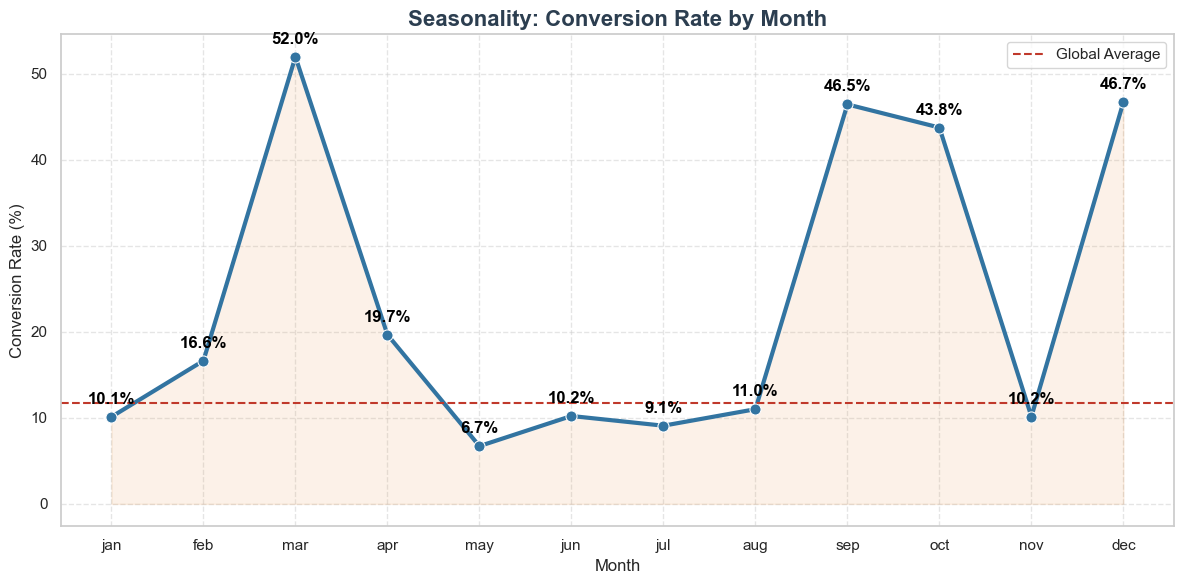

In [11]:
# ==============================================
# VIZ 2: Seasonality of Conversions (Line Chart)
# ==============================================

# A. Prepare Data
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
seasonal_stats = marketing_campaign_df.groupby('last_contact_month')['has_subscribed_target'].mean().reindex(month_order).reset_index()
seasonal_stats['conversion_rate_pct'] = seasonal_stats['has_subscribed_target'] * 100

# B. Plot
plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(
    data=seasonal_stats, 
    x='last_contact_month', 
    y='conversion_rate_pct', 
    marker='o', 
    markersize=8,
    linewidth=3,
    color=custom_colors[0] # custom Blue
)

# C. Customize
plt.title('Seasonality: Conversion Rate by Month', fontsize=16, fontweight='bold', color='#2C3E50')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Highlight the peak with the "Red"
plt.axhline(y=global_mean, color=custom_colors[2], linestyle='--', label='Global Average')

# Fill under line with the "Orange" 
plt.fill_between(seasonal_stats['last_contact_month'], seasonal_stats['conversion_rate_pct'], color=custom_colors[3], alpha=0.1)
plt.legend()

# D. Add Values on Points
for x, y in zip(seasonal_stats['last_contact_month'], seasonal_stats['conversion_rate_pct']):
    if pd.notna(y):
        # Make the text the same Green 
        plt.text(x, y+1.5, f"{y:.1f}%", ha='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()

C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\2122585597.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


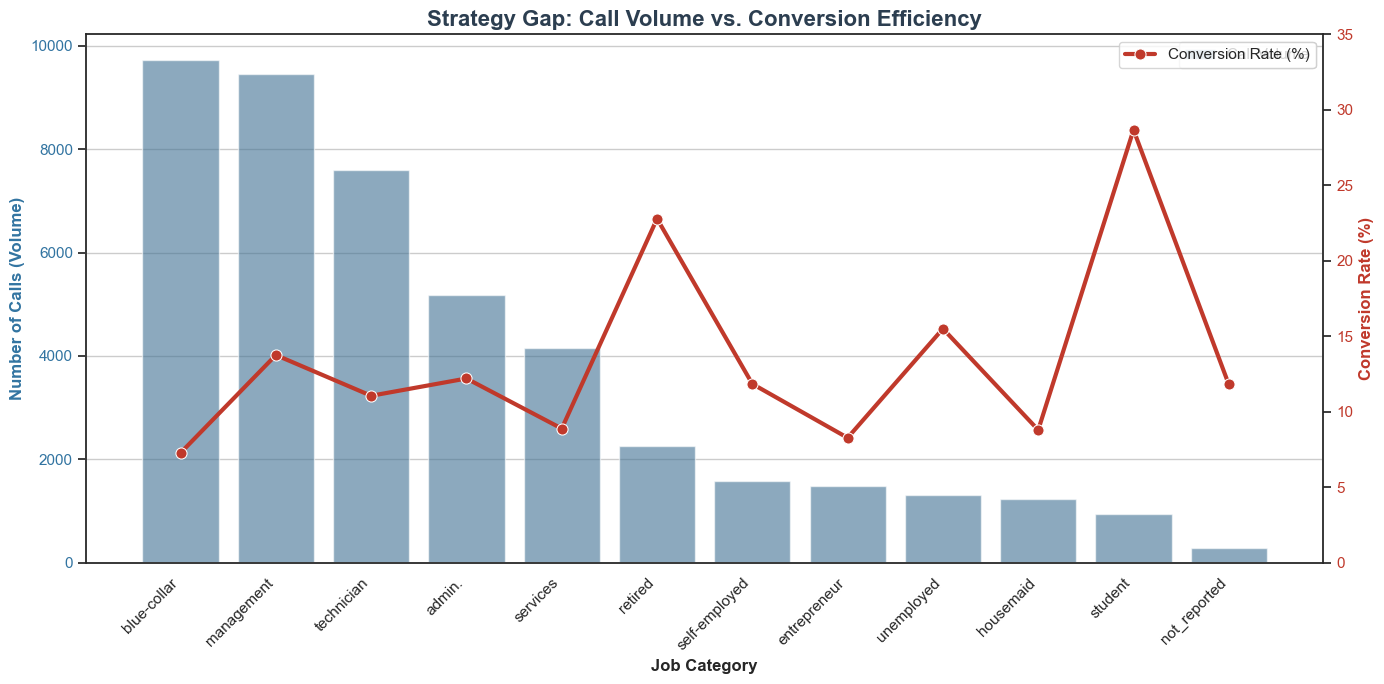

In [12]:
# 2. Prepare Data
#Group by Job (on the whole dataframe) and then specify column inside agg
job_analysis = marketing_campaign_df.groupby('job_category').agg(
    volume=('has_subscribed_target', 'count'),
    conversion_rate=('has_subscribed_target', 'mean')
).reset_index()

# Convert rate to percentage
job_analysis['conversion_rate_pct'] = job_analysis['conversion_rate'] * 100

# Sort by Volume (Highest to Lowest) to see where the effort is going
job_analysis = job_analysis.sort_values('volume', ascending=False)

# 3. Setup Plot
# Create the figure and the first axis (for Bars)
fig, ax1 = plt.subplots(figsize=(14, 7))
sns.set_theme(style="white") # Cleaner background for dual axis

# Custom Colors
color_volume = "#3274A1"  # Blue
color_rate = "#C0392B"    # Red

# 4. Plot 1: Volume (Bar Chart) on Left Axis
sns.barplot(
    data=job_analysis, 
    x='job_category', 
    y='volume', 
    color=color_volume, 
    alpha=0.6, 
    ax=ax1,
    label='Call Volume'
)

# 5. Plot 2: Conversion Rate (Line Chart) on Right Axis
ax2 = ax1.twinx() # Create a second y-axis sharing the same x-axis
sns.lineplot(
    data=job_analysis, 
    x='job_category', 
    y='conversion_rate_pct', 
    color=color_rate, 
    marker='o', 
    linewidth=3, 
    markersize=8,
    ax=ax2,
    label='Conversion Rate (%)'
)

# 6. Customize Axes
# Axis 1 (Left - Volume)
ax1.set_xlabel('Job Category', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Calls (Volume)', fontsize=12, color=color_volume, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_volume)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Axis 2 (Right - Rate)
ax2.set_ylabel('Conversion Rate (%)', fontsize=12, color=color_rate, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_rate)
ax2.set_ylim(0, 35) # Fix scale to make it readable (max rate is ~28%)

# 7. Add Title and Legends
plt.title('Strategy Gap: Call Volume vs. Conversion Efficiency', fontsize=16, fontweight='bold', color='#2C3E50')

# Manually adding a combined legend (optional, but cleaner)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper center')

plt.tight_layout()
plt.show()

## Hypothesis 5: A Machine Learning model trained on {Client + Macro + Campaign} features outperforms a model trained on {Client} features alone¶

In [13]:
ml_feature_set = pd.read_csv("../data/clean/denormalized_data.csv")

In [14]:
from machine_learning import prepare_duel_datasets

# 1. PREPROCESSING: Clean and Split
X_a, X_b, y = prepare_duel_datasets(ml_feature_set)

# 3. Verify the results
print("Success! Data is now preprocessed and ready.")

Success! Data is now preprocessed and ready.


In [28]:
from machine_learning import train_and_evaluate

f1_client = train_and_evaluate(X_a, y, "Model A (Client Only)")
f1_full = train_and_evaluate(X_b, y, "Model B (Integrated - The Grand Finale)")

print(f"\n ROI Justification: Integrated features provided a {((f1_full/f1_client)-1)*100:.2f}% lift in F1-Score!")




--- Model A (Client Only) Results ---
F1-Score: 0.3163
AUC-ROC:  0.6941

--- Model B (Integrated - The Grand Finale) Results ---
F1-Score: 0.5050
AUC-ROC:  0.8097

 ROI Justification: Integrated features provided a 59.66% lift in F1-Score!


In [18]:

# We divide the interest rates into 3 categories: Low, Medium, and High
ml_feature_set['rate_bin'] = pd.qcut(ml_feature_set['ecb_rate'], q=3, labels=['Low', 'Medium', 'High'])

# 2. (Optional) If you also get a KeyError for 'balance_segment', create it here:
ml_feature_set['balance_segment'] = pd.qcut(ml_feature_set['account_balance'], q=3, labels=['Bronze', 'Silver', 'Gold'])

# 3. Now call your statistical tests
from machine_learning import test_stat_significance

test_stat_significance(ml_feature_set, 'rate_bin')      # Validates H1
test_stat_significance(ml_feature_set, 'contact_type')  # Validates H3
test_stat_significance(ml_feature_set, 'balance_segment') # Validates H4

--- Statistical Test: rate_bin vs Target ---
Chi-Square Statistic: 3095.78
P-Value: 0.0000e+00
✅ RESULT: Significant (p < 0.05). 
We reject the Null Hypothesis. The variables are dependent.
------------------------------
--- Statistical Test: contact_type vs Target ---
Chi-Square Statistic: 1035.71
P-Value: 1.2517e-225
✅ RESULT: Significant (p < 0.05). 
We reject the Null Hypothesis. The variables are dependent.
------------------------------
--- Statistical Test: balance_segment vs Target ---
Chi-Square Statistic: 398.98
P-Value: 2.3103e-87
✅ RESULT: Significant (p < 0.05). 
We reject the Null Hypothesis. The variables are dependent.
------------------------------


In [19]:
# 1. Create the Contingency Table first
# Replace 'rate_bin' with the column you want to test (e.g., 'job_category', 'contact_type')
contingency_table = pd.crosstab(ml_feature_set['rate_bin'], ml_feature_set['has_subscribed_target'])

# Check expected frequencies
chi2, p, dof, expected = chi2_contingency(contingency_table)
if (expected < 5).any():
    print("Warning: Some cells have too few samples. Group categories together.")
else:
    print("Test is valid: All expected frequencies are > 5.")

Test is valid: All expected frequencies are > 5.


# test

In [30]:
ml_feature_set.columns

Index(['client_age', 'job_category', 'marital_status', 'education_level',
       'has_credit_default', 'account_balance', 'has_housing_loan',
       'has_personal_loan', 'contact_type', 'last_contact_day',
       'last_contact_month', 'call_duration_sec', 'contacts_this_campaign',
       'days_since_prev_contact', 'nb_previous_interactions',
       'prev_campaign_outcome', 'has_subscribed_target', 'month_num', 'year',
       'call_date', 'economics_id', 'campaign_id', 'campaign_name',
       'campaign_start_date', 'campaign_end_date', 'campaign_channel',
       'ecb_rate', 'date', 'rate_description', 'currency', 'rate_bin',
       'balance_segment'],
      dtype='object')

C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\4113842005.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\davyg\AppData\Local\Temp\ipykernel_25008\4113842005.py:73: UserWarning: 
The palette list has fewer values (4) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


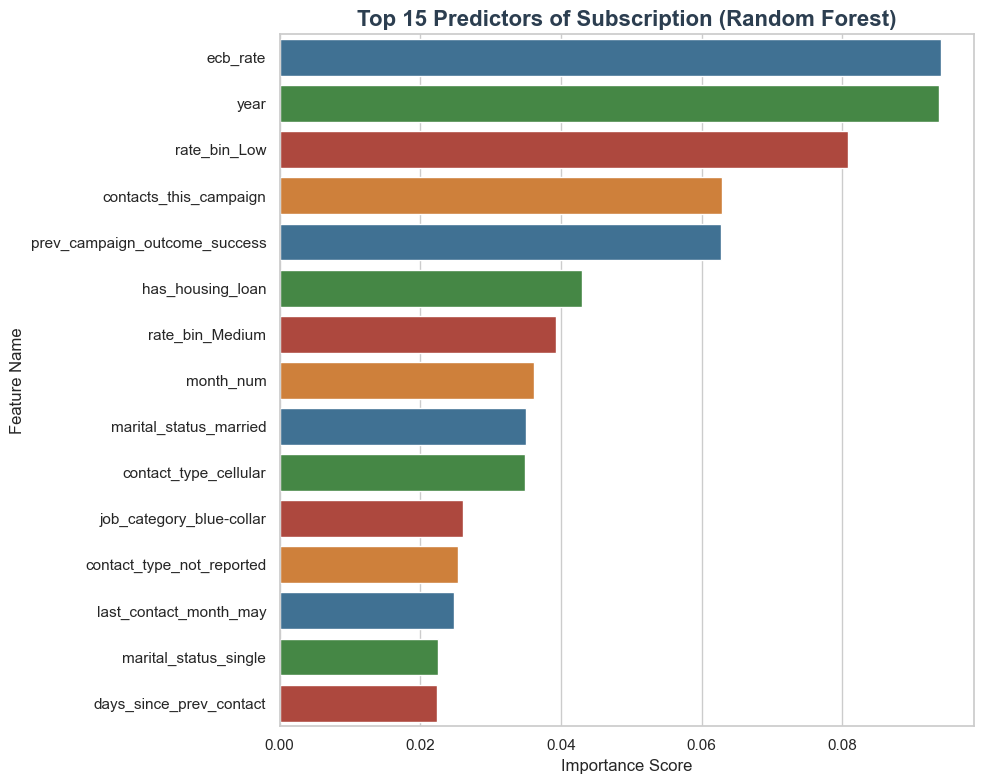

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ==============================================
# 0. SETUP YOUR CUSTOM COLORS
# ==============================================
# Blue, Green, Red, Orange
custom_colors = ["#3274A1", "#3A923A", "#C0392B", "#E67E22"]
sns.set_palette(sns.color_palette(custom_colors))
sns.set_theme(style="whitegrid")

# ==============================================
# 1. PREPARE DATA & TRAIN MODEL (Same as before)
# ==============================================

# Define columns to drop
drop_cols = [
    'has_subscribed_target', 'economics_id', 'campaign_id', 'call_date', 
    'campaign_start_date', 'campaign_end_date', 'date', 'currency', 
    'rate_description', 'campaign_name', 'call_duration_sec' 
]
existing_drop_cols = [c for c in drop_cols if c in ml_feature_set.columns]
X = ml_feature_set.drop(columns=existing_drop_cols)
y = ml_feature_set['has_subscribed_target']

# Identify columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

# Fit
pipeline.fit(X, y)

# ==============================================
# 2. EXTRACT FEATURE NAMES & IMPORTANCE
# ==============================================
preprocessor_step = pipeline.named_steps['pre']
ohe_feature_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = num_cols + list(ohe_feature_names)
importances = pipeline.named_steps['clf'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# ==============================================
# 3. VISUALIZE WITH CUSTOM COLORS
# ==============================================

plt.figure(figsize=(10, 8))

# Plot Top 15 Features
sns.barplot(
    data=feature_importance_df.head(15), 
    x='Importance', 
    y='Feature', 
    palette=custom_colors # Applied here
)

# Customizing Title and Labels
plt.title('Top 15 Predictors of Subscription (Random Forest)', fontsize=16, fontweight='bold', color='#2C3E50')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

plt.tight_layout()
plt.show()

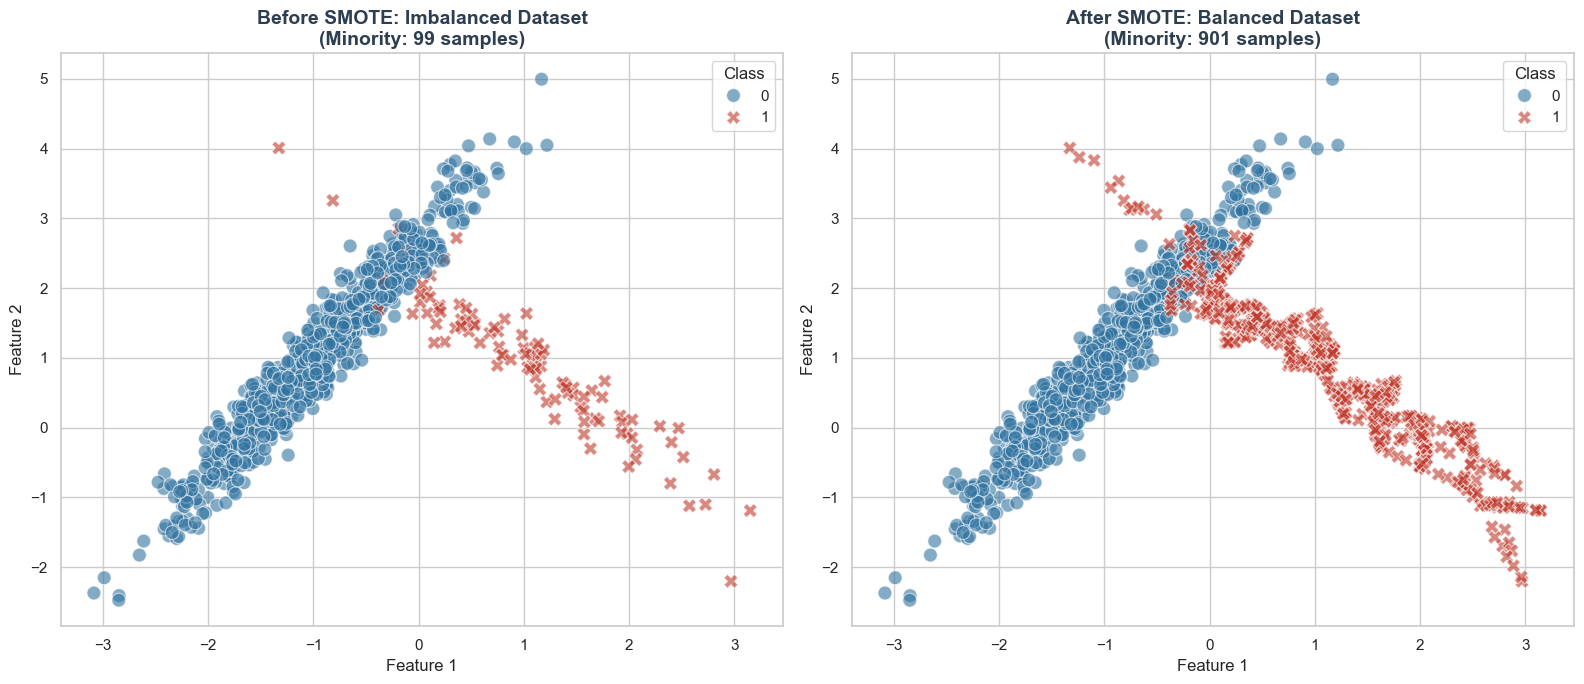

In [35]:
from machine_learning import visualize_smote

# Call the function 
visualize_smote(
    n_samples=1000,           
    weights=[0.90],           # 90% Imbalance (Similar the real data)
    colors=["#3274A1", "#C0392B"]
)

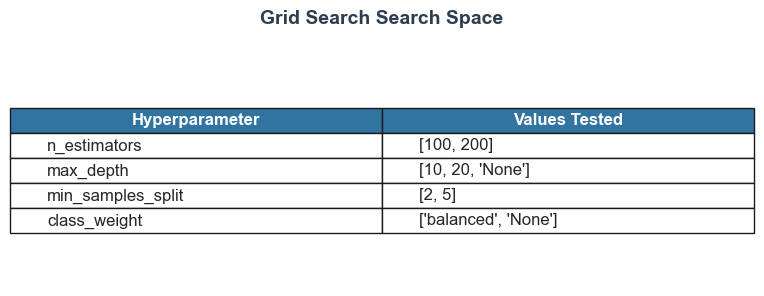

In [37]:
from machine_learning import visualize_hyperparameters
visualize_hyperparameters()

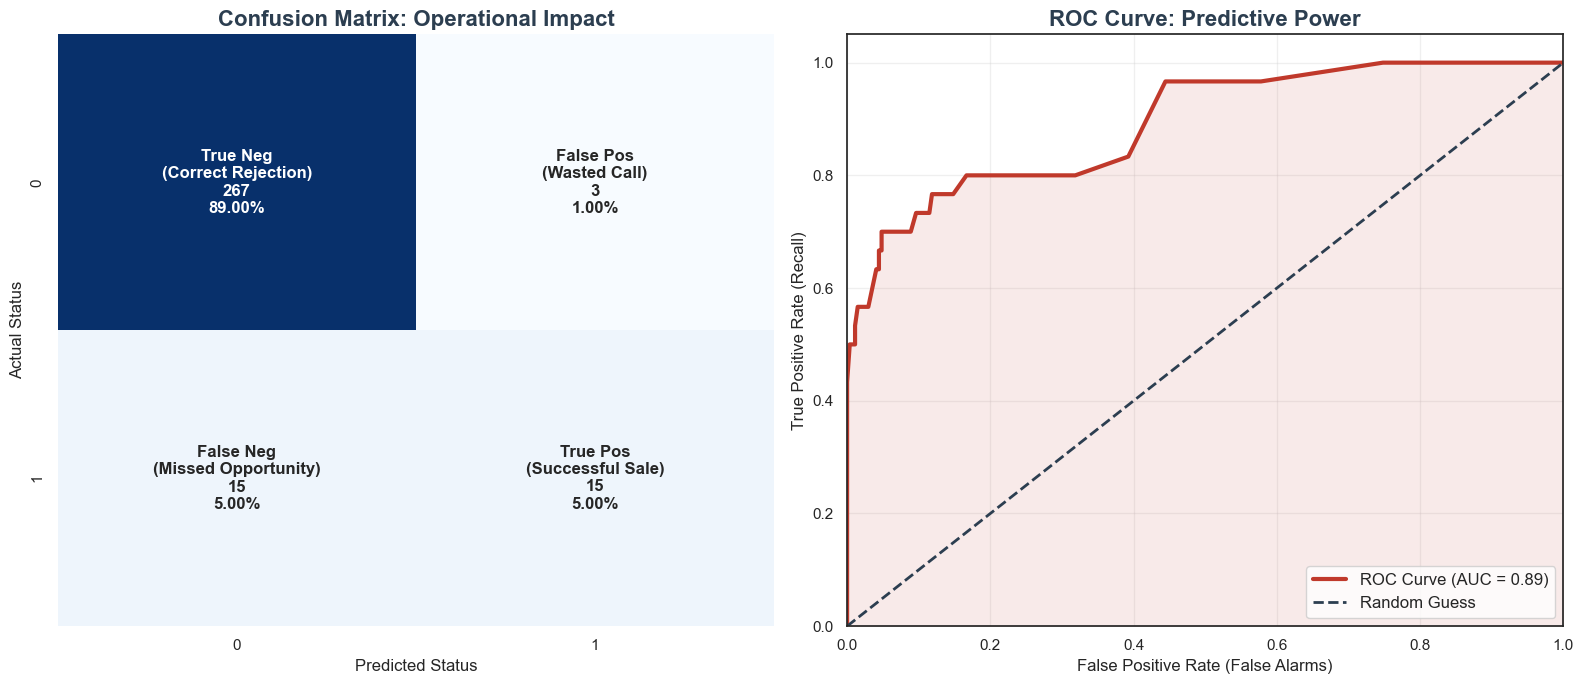

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ==============================================
# 0. SETUP & GENERATE SAMPLE DATA (For Demo)
# ==============================================
# We create a fake dataset to make this code runnable immediately
# In your real project, skip this and use your actual X_test, y_test
X, y = make_classification(n_samples=1000, weights=[0.9], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] # Probability for Class 1

# ==============================================
# 1. SETUP PLOT STYLE
# ==============================================
# Blue/Red Theme
custom_colors = ["#3274A1", "#C0392B"]
sns.set_palette(sns.color_palette(custom_colors))
sns.set_theme(style="white") # Clean background

# Create Figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ==============================================
# 2. PLOT 1: CONFUSION MATRIX (The "Business Truth")
# ==============================================
cm = confusion_matrix(y_test, y_pred)

# Define Business Labels for the Matrix
group_names = ['True Neg\n(Correct Rejection)', 'False Pos\n(Wasted Call)', 
               'False Neg\n(Missed Opportunity)', 'True Pos\n(Successful Sale)']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Plot Heatmap
sns.heatmap(
    cm, 
    annot=labels, 
    fmt='', 
    cmap='Blues', 
    cbar=False, 
    ax=axes[0], 
    annot_kws={"fontsize":12, "fontweight":"bold"}
)

axes[0].set_title('Confusion Matrix: Operational Impact', fontsize=16, fontweight='bold', color='#2C3E50')
axes[0].set_ylabel('Actual Status', fontsize=12)
axes[0].set_xlabel('Predicted Status', fontsize=12)

# ==============================================
# 3. PLOT 2: ROC CURVE (The "Model Power")
# ==============================================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the Curve
axes[1].plot(
    fpr, tpr, 
    color='#C0392B', # Your Brand Red 
    lw=3, 
    label=f'ROC Curve (AUC = {roc_auc:.2f})'
)

# Plot the Random Guess Line (Diagonal)
axes[1].plot([0, 1], [0, 1], color='#2C3E50', lw=2, linestyle='--', label='Random Guess')

# Customization
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate (False Alarms)', fontsize=12)
axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[1].set_title('ROC Curve: Predictive Power', fontsize=16, fontweight='bold', color='#2C3E50')
axes[1].legend(loc="lower right", fontsize=12)
axes[1].grid(True, alpha=0.3)

# Add area fill under curve
axes[1].fill_between(fpr, tpr, color='#C0392B', alpha=0.1)

plt.tight_layout()
plt.show()

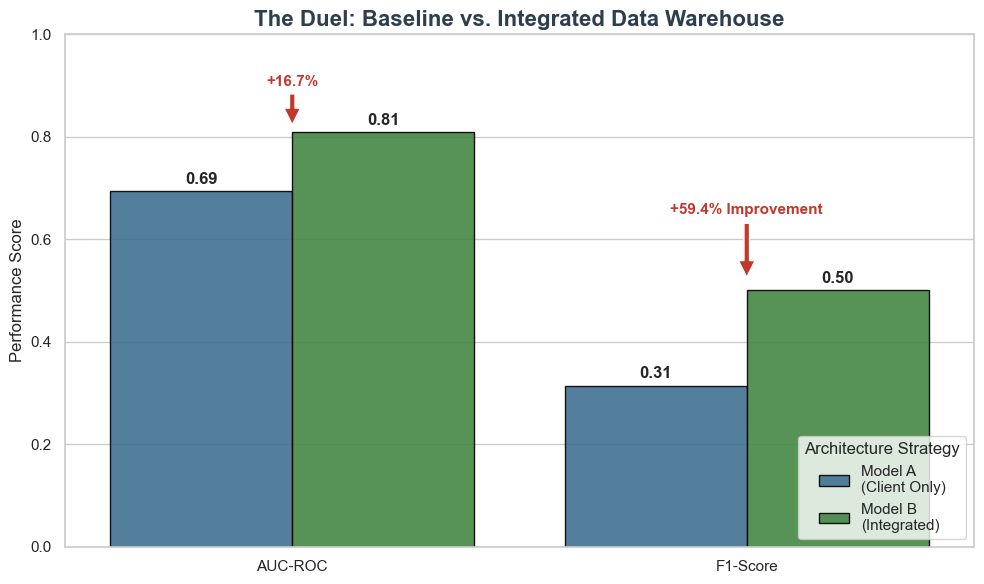

In [44]:
# ==============================================
# 0. SETUP DATA (Hardcoded from your results)
# ==============================================
# Model A: Client Data Only (Baseline)
# Model B: Client + Macro + Campaign (Integrated)
data = {
    'Model': ['Model A\n(Client Only)', 'Model B\n(Integrated)', 'Model A\n(Client Only)', 'Model B\n(Integrated)'],
    'Metric': ['AUC-ROC', 'AUC-ROC', 'F1-Score', 'F1-Score'],
    'Score': [0.6939, 0.8101, 0.3147, 0.5017]
}

df_duel = pd.DataFrame(data)

# Calculate Lift for the annotation
lift_f1 = ((0.5017 - 0.3147) / 0.3147) * 100
lift_auc = ((0.8101 - 0.6939) / 0.6939) * 100

# ==============================================
# 1. SETUP PLOT STYLE
# ==============================================
# Blue (Baseline), Green (Winner)
custom_colors = ["#3274A1", "#3A923A"] 
sns.set_palette(sns.color_palette(custom_colors))
sns.set_theme(style="whitegrid")

# Create Figure
fig, ax = plt.subplots(figsize=(10, 6))

# ==============================================
# 2. PLOT: GROUPED BAR CHART
# ==============================================
# We use 'Metric' as X and 'Model' as Hue to compare them side-by-side
barplot = sns.barplot(
    data=df_duel, 
    x='Metric', 
    y='Score', 
    hue='Model', 
    palette=custom_colors,
    edgecolor="black",
    linewidth=1,
    alpha=0.9
)

# ==============================================
# 3. CUSTOMIZE & ANNOTATE
# ==============================================
ax.set_ylim(0, 1.0) # Scale from 0 to 100%
ax.set_title('The Duel: Baseline vs. Integrated Data Warehouse', fontsize=16, fontweight='bold', color='#2C3E50')
ax.set_ylabel('Performance Score', fontsize=12)
ax.set_xlabel('')

# Add the numbers on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontweight='bold')

# Add "Lift" Arrows (Manual Annotation)
# Coordinates are approximate based on bar positions
# F1-Score Lift
plt.annotate(
    f'+{lift_f1:.1f}% Improvement', 
    xy=(1.0, 0.52), xytext=(1.0, 0.65),
    arrowprops=dict(facecolor='#C0392B', shrink=0.05),
    ha='center', fontsize=11, fontweight='bold', color='#C0392B'
)

# AUC Lift
plt.annotate(
    f'+{lift_auc:.1f}%', 
    xy=(0.0, 0.82), xytext=(0.0, 0.90),
    arrowprops=dict(facecolor='#C0392B', shrink=0.05),
    ha='center', fontsize=11, fontweight='bold', color='#C0392B'
)

# Move legend to bottom right
plt.legend(loc='lower right', title='Architecture Strategy')

plt.tight_layout()
plt.show()